<a href="https://colab.research.google.com/github/aryan-at-ul/image_segmentation/blob/main/pneumonia_image_as_graph_classification_resnet_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install imageio==2.22.4
!pip install llvmlite==0.39.1
# !pip install matplotlib==3.6.2
!pip install matplotlib==3.1.3
!pip install networkx==2.8.8
!pip install numba==0.56.4
!pip install numpy
!pip install opencv-python==4.6.0.66
!pip install psutil==5.9.4
!pip install pytz==2022.6
!pip install scikit-image==0.19.3
!pip install scipy 
!pip install timm==0.6.12
!pip install torch==1.13.0
!pip install torchinfo==1.7.1
!pip install torchvision==0.14.0
# tqdm @ file:///opt/conda/conda-bld/tqdm_1647339053476/work
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install gdown

In [2]:
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx
from torch_geometric.loader import DataLoader
import os
from sklearn.model_selection import KFold
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
from torch_geometric.nn import GraphConv, TopKPooling, GatedGraphConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool
# import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import pickle
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
# from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv
import random
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool
import torch.nn as nn
from itertools import zip_longest
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import global_mean_pool

In [3]:
!curl -o train_dataloader.pkl -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1luFl1j_zf07eD_CHrpprXPz1udCIhjUU'
!curl -o test_dataloader.pkl -L 'https://drive.google.com/uc?export=download&confirm=yes&id=115kJ5EzpCL7TXLKUotJXuK6ngwcyC84E'
!curl -o val_dataloader.pkl -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1SlQqiqT6vAlotmT9xc5PMQdeFLTh_PUa'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  109M  100  109M    0     0  25.0M      0  0:00:04  0:00:04 --:--:-- 36.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 13.0M  100 13.0M    0     0  2732k      0  0:00:04  0:00:04 --:--:--  332M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  344k  100  344k    0     0   294k      0  0:00:01  0:00:01 --:--:--  813k


In [ ]:
!du -sh * 

In [4]:

curretn_path = os.getcwd()
path = f"{curretn_path}"

embed_dim = 128

def load_all_from_one_folder(path,type = 0):
    all_files = os.listdir(path)
    all_data = []
    k = 0
    for one_g in all_files:
        name = one_g.split(".")[0]
        G = nx.read_gpickle(f"{path}/{one_g}")  

        data = from_networkx(G)
        if type:
            data.y = [1]
        else:
            data.y = [0]
        k+= 1
        data.x = torch.Tensor([torch.flatten(val).tolist() for val in data.x])#nx.get_node_attributes(G,'image')
        data.name = name
        all_data.append(data)
    return all_data


def permute_array(array):
    permuted_array = []
    for i in range(len(array)):
        permuted_array.append(array[i])
    return permuted_array

def check_if_a_with_name_exisi(path,name):
    all_files = os.listdir(path)
    if name in all_files:
        return True
    else:
        return False





def dataloader():
    """
    load train and test data
    """
    print("loading data")
    train_dataset, test_dataset, val_dataset = None, None, None

    if not check_if_a_with_name_exisi(curretn_path,'train_dataloader.pkl'):

        train_normal = load_all_from_one_folder(f"{path}/train/NORMAL")
        train_pneumonia = load_all_from_one_folder(f"{path}/train/PNEUMONIA",1)

        test_normal = load_all_from_one_folder(f"{path}/test/NORMAL")
        test_pneumonia = load_all_from_one_folder(f"{path}/test/PNEUMONIA",1)

        val_normal = load_all_from_one_folder(f"{path}/val/NORMAL")
        val_pneumonia = load_all_from_one_folder(f"{path}/val/PNEUMONIA",1)


        train_data_arr = train_normal + train_pneumonia
        test_data_arr = test_normal + test_pneumonia
        val_data_arr = val_normal + val_pneumonia
        # all_data = permute_array(all_data)
        random.shuffle(train_data_arr)
        random.shuffle(test_data_arr)
        random.shuffle(val_data_arr)
        
        train_dataset = train_data_arr#all_data[:int(len(all_data)*0.8)]
        val_dataset = val_data_arr#all_data[int(len(all_data)*0.8):int(len(all_data)*0.8) + 100]
        test_dataset = test_data_arr#all_data[int(len(all_data)*0.8):]
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False,drop_last=True)
        # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True,drop_last=True)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False,drop_last=True)

        with open('train_dataloader.pkl', 'wb') as f:
            pickle.dump(train_loader, f)

        with open('test_dataloader.pkl', 'wb') as f:
            pickle.dump(test_loader, f)
        
        with open('val_dataloader.pkl', 'wb') as f:
            pickle.dump(val_loader, f)
    else:
        with open('train_dataloader.pkl', 'rb') as f:
            train_loader = pickle.load(f)

        with open('test_dataloader.pkl', 'rb') as f:
            test_loader = pickle.load(f)
        
        with open('val_dataloader.pkl', 'rb') as f:
            val_loader = pickle.load(f)

    #dataset_from_dataloader = train_loader.dataset
    return train_loader, test_loader, train_loader.dataset, test_loader.dataset, val_loader, val_loader.dataset



train_loader, test_loader, train_dataset, test_dataset, val_loader, val_dataset = dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = [data.to(device) for data in train_dataset]
val_dataset = [data.to(device) for data in val_dataset]
test_dataset = [data.to(device) for data in test_dataset]


dataset = ConcatDataset([train_dataset, val_dataset])


print("data loaded")

loading data
data loaded


In [5]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(512, 256)
        self.conv2 = GCNConv(256, 128)
        self.conv3 = GCNConv(128,64)
        self.conv4 = GCNConv(64, 32)
        self.lin1 = Linear(32, 16)
        self.lin = Linear(16, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_mean_pool(x, batch)  

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=512) # based on feature size
model.to(device)

GCN(
  (conv1): GCNConv(512, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
def train():
    model.train()

    for data in train_loader: 
        # data = data.to(device)
        out = model(data.x, data.edge_index, data.batch) 
        data.y = torch.Tensor(data.y)
        data.y = torch.Tensor(torch.flatten(data.y))
        data.y = data.y.type(torch.LongTensor)
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()
        optimizer.zero_grad()  

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  
        #  data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  
         data.y = torch.Tensor(data.y)
         pred = out.argmax(dim=1).view(-1,1)  
         correct += int((pred.to('cpu') == data.y.to('cpu')).sum())  
         acc = correct / len(loader.dataset)
        #  if acc > 0.91:
        #      torch.save(model.state_dict(), 'model_res_10sp.pt')
     return correct / len(loader.dataset) 





In [8]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    correct = 0.0
    ite = 0
    for data in dataloader:

        # print(data)
        ite += 1
        out = model(data.x, data.edge_index, data.batch) 
        data.y = torch.Tensor(data.y)
        data.y = torch.Tensor(torch.flatten(data.y))
        data.y = data.y.type(torch.LongTensor)
        pred = out.argmax(dim=1).view(-1,1)
        # cfm = confusion_matrix(data.y,pred)
        # print("train",cfm)
        # tn, fp, fn, tp = confusion_matrix(data.y, pred).ravel()
        # print(f"tn: {tn}, tp: {tp}, fp : {fp}, fn : {fn}")
        acc = accuracy_score(data.y, pred.cpu())
        # print("accuracy train :",acc)
        loss = criterion(out.to(device), data.y.to(device))
        loss.backward()  
        train_loss+=loss
        optimizer.step()
        optimizer.zero_grad() 
        # train_correct += int((pred.to(device) == data.y).sum()) 
        correct += acc



    return train_loss.item()/ite,correct/ite
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    ite = 0
    for data in dataloader:
        ite += 1
        out = model(data.x, data.edge_index, data.batch) 
        data.y = torch.Tensor(data.y)
        data.y = torch.Tensor(torch.flatten(data.y))
        data.y = data.y.type(torch.LongTensor)
        pred = out.argmax(dim=1).view(-1,1)
        # cfm = confusion_matrix(data.y,pred)
        # print(cfm)
        acc = accuracy_score(data.y, pred.cpu())
        loss = criterion(out.to(device), data.y.to(device))
        loss.backward() 
        valid_loss+=loss
        optimizer.step()
        optimizer.zero_grad() 
        val_correct += acc #int((pred == data.y).sum()) 

    return valid_loss.item()/ite,val_correct/ite  


In [9]:

splits=KFold(n_splits=5,shuffle=True,random_state=42)
splits

KFold(n_splits=5, random_state=42, shuffle=True)

In [10]:
history = {'train_loss': [], 'val_loss': [],'train_acc':[],'val_acc':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))
    print(len(train_idx),len(val_idx))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler)
    

    for epoch in range(10):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,val_loader,criterion)

        train_loss = train_loss 
        train_acc = train_correct 
        test_loss = test_loss 
        test_acc = test_correct 
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} AVG Training Acc {:.4f} % AVG Val Acc {:.4f} %".format(epoch + 1,
                                                                                                             10,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['val_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(test_acc)

Fold 1
4185 1047
Epoch:1/10 AVG Training Loss:0.374 AVG Val Loss:0.214 AVG Training Acc 0.8299 % AVG Val Acc 0.9156 %
Epoch:2/10 AVG Training Loss:0.176 AVG Val Loss:0.150 AVG Training Acc 0.9382 % AVG Val Acc 0.9403 %
Epoch:3/10 AVG Training Loss:0.118 AVG Val Loss:0.149 AVG Training Acc 0.9617 % AVG Val Acc 0.9439 %
Epoch:4/10 AVG Training Loss:0.141 AVG Val Loss:0.117 AVG Training Acc 0.9497 % AVG Val Acc 0.9522 %
Epoch:5/10 AVG Training Loss:0.108 AVG Val Loss:0.107 AVG Training Acc 0.9620 % AVG Val Acc 0.9609 %
Epoch:6/10 AVG Training Loss:0.090 AVG Val Loss:0.116 AVG Training Acc 0.9685 % AVG Val Acc 0.9533 %
Epoch:7/10 AVG Training Loss:0.088 AVG Val Loss:0.120 AVG Training Acc 0.9689 % AVG Val Acc 0.9506 %
Epoch:8/10 AVG Training Loss:0.115 AVG Val Loss:0.089 AVG Training Acc 0.9564 % AVG Val Acc 0.9697 %
Epoch:9/10 AVG Training Loss:0.103 AVG Val Loss:0.108 AVG Training Acc 0.9635 % AVG Val Acc 0.9609 %
Epoch:10/10 AVG Training Loss:0.083 AVG Val Loss:0.101 AVG Training Acc 0.

In [11]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['val_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['val_acc'])

print('Performance of {} fold cross validation'.format(5))
print("Average Training Loss: {:.4f} \t Average Val Loss: {:.4f} \t Average Training Acc: {:.4f} \t Average VAl Acc: {:.4f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  

Performance of 5 fold cross validation
Average Training Loss: 0.0810 	 Average Val Loss: 0.0734 	 Average Training Acc: 0.9705 	 Average VAl Acc: 0.9724


In [12]:
chunks = [list(chunk) for chunk in zip_longest(*[iter(history['train_acc'])]*(len(history['train_acc'])//5))]
history['train_acc'] = np.divide(np.sum(chunks,axis=0),5)

chunks = [list(chunk) for chunk in zip_longest(*[iter(history['val_acc'])]*(len(history['val_acc'])//5))]
history['val_acc'] = np.divide(np.sum(chunks,axis=0),5)

chunks = [list(chunk) for chunk in zip_longest(*[iter(history['train_loss'])]*(len(history['train_loss'])//5))]
history['train_loss'] = np.divide(np.sum(chunks,axis=0),5)

chunks = [list(chunk) for chunk in zip_longest(*[iter(history['val_loss'])]*(len(history['val_loss'])//5))]
history['val_loss'] = np.divide(np.sum(chunks,axis=0),5)

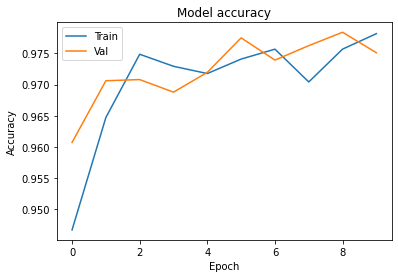

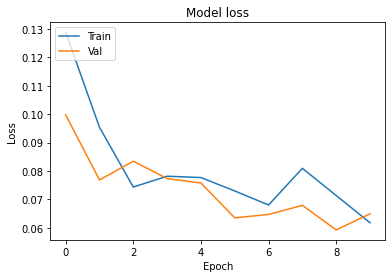

In [13]:
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
test_acc = test(test_loader)
print(f'Test Acc: {test_acc:.4f}')
print("number of paramteres for this model",sum(p.numel() for p in model.parameters()))

Test Acc: 0.8622
number of paramteres for this model 175122
